In [159]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking r un or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/formula-1-world-championship-1950-2020/races.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructor_results.csv
/kaggle/input/formula-1-world-championship-1950-2020/drivers.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructors.csv
/kaggle/input/formula-1-world-championship-1950-2020/lap_times.csv
/kaggle/input/formula-1-world-championship-1950-2020/status.csv
/kaggle/input/formula-1-world-championship-1950-2020/driver_standings.csv
/kaggle/input/formula-1-world-championship-1950-2020/seasons.csv
/kaggle/input/formula-1-world-championship-1950-2020/pit_stops.csv
/kaggle/input/formula-1-world-championship-1950-2020/sprint_results.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructor_standings.csv
/kaggle/input/formula-1-world-championship-1950-2020/results.csv
/kaggle/input/formula-1-world-championship-1950-2020/circuits.csv
/kaggle/input/formula-1-world-championship-1950-2020/qualifying.csv


In [219]:
# Enhanced Formula 1 Race Prediction Pipeline with Advanced ML Techniques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import optuna
import warnings
warnings.filterwarnings('ignore')

In [220]:
# Set plotting style and suppress optuna logs
plt.style.use('seaborn-v0_8')
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [164]:
# Load all CSV files from Formula 1 dataset
base_path = "/kaggle/input/formula-1-world-championship-1950-2020/"
files = ["circuits.csv", "constructor_results.csv", "constructor_standings.csv", "constructors.csv",
         "driver_standings.csv", "drivers.csv", "lap_times.csv", "pit_stops.csv", "qualifying.csv",
         "races.csv", "results.csv", "seasons.csv", "sprint_results.csv", "status.csv"]

In [165]:
# Load datasets into dictionaries for easy access
dfs = {}
for file in files:
    name = file.replace('.csv', '')
    dfs[name] = pd.read_csv(base_path + file)

# Extract individual dataframes for easier reference
circuits, constructor_results, constructor_standings = dfs['circuits'], dfs['constructor_results'], dfs['constructor_standings']
constructors, driver_standings, drivers = dfs['constructors'], dfs['driver_standings'], dfs['drivers']
lap_times, pit_stops, qualifying = dfs['lap_times'], dfs['pit_stops'], dfs['qualifying']
races, results, seasons, sprint_results, status = dfs['races'], dfs['results'], dfs['seasons'], dfs['sprint_results'], dfs['status']

In [166]:
# Filter data for recent years (2018-2024) for model training
recent_races = races[(races['year'] >= 2018) & (races['year'] <= 2024)]
recent_race_ids = recent_races['raceId'].unique()


In [139]:
# Filter all datasets to recent races only
recent_datasets = {}
for name, df in [('driver_standings', driver_standings), ('constructor_standings', constructor_standings),
                 ('results', results), ('lap_times', lap_times), ('pit_stops', pit_stops), ('qualifying', qualifying)]:
    if 'raceId' in df.columns:
        recent_datasets[name] = df[df['raceId'].isin(recent_race_ids)]

In [221]:
# Create base dataframe with core race results
base_df = recent_datasets['results'][['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder', 'points', 'statusId']].copy()
base_df.rename(columns={'positionOrder': 'final_position'}, inplace=True)

In [222]:
# Merge driver standings data
driver_standings_clean = recent_datasets['driver_standings'].rename(columns={'points': 'points_driver_standing', 'wins': 'wins_driver_standing'})
base_df = base_df.merge(driver_standings_clean[['raceId', 'driverId', 'points_driver_standing', 'wins_driver_standing']], 
                        on=['raceId', 'driverId'], how='left')

# Merge constructor standings data
constructor_standings_clean = recent_datasets['constructor_standings'].rename(columns={'points': 'points_constructor_standing', 'wins': 'wins_constructor_standing'})
base_df = base_df.merge(constructor_standings_clean[['raceId', 'constructorId', 'points_constructor_standing', 'wins_constructor_standing']], 
                        on=['raceId', 'constructorId'], how='left')

# Aggregate lap times statistics
lap_agg = recent_datasets['lap_times'].groupby(['raceId', 'driverId']).agg({
    'milliseconds': ['mean', 'min', 'max', 'std'],
    'lap': 'count'
}).reset_index()
lap_agg.columns = ['raceId', 'driverId', 'lap_ms_mean', 'lap_ms_min', 'lap_ms_max', 'lap_ms_std', 'total_laps']
base_df = base_df.merge(lap_agg, on=['raceId', 'driverId'], how='left')

# Aggregate pit stop statistics
pit_agg = recent_datasets['pit_stops'].groupby(['raceId', 'driverId']).agg({
    'milliseconds': ['count', 'mean', 'sum']
}).reset_index()
pit_agg.columns = ['raceId', 'driverId', 'num_pitstops', 'avg_pit_duration', 'total_pit_duration']
base_df = base_df.merge(pit_agg, on=['raceId', 'driverId'], how='left')


In [223]:
# Extract best qualifying time
def get_best_qual_time(row):
    for q in ['q1', 'q2', 'q3']:
        if pd.notnull(row[q]):
            return row[q]
    return None

def time_to_seconds(t):
    try:
        if pd.isna(t) or t == '' or str(t) == 'nan':
            return None
        m, s = str(t).split(':')
        return float(m) * 60 + float(s)
    except:
        return None

In [224]:
recent_datasets['qualifying']['best_qual_time'] = recent_datasets['qualifying'].apply(get_best_qual_time, axis=1)
recent_datasets['qualifying']['best_qual_seconds'] = recent_datasets['qualifying']['best_qual_time'].apply(time_to_seconds)
qual_data = recent_datasets['qualifying'][['raceId', 'driverId', 'position', 'best_qual_seconds']]
base_df = base_df.merge(qual_data, on=['raceId', 'driverId'], how='left')



In [225]:
# Add sprint race data
sprint_with_year = sprint_results.merge(races[['raceId', 'year']], on='raceId', how='left')
sprint_recent = sprint_with_year[sprint_with_year['year'] >= 2021]
sprint_data = sprint_recent[['raceId', 'driverId', 'positionOrder', 'points']].rename(
    columns={'positionOrder': 'sprint_position', 'points': 'sprint_points'})
base_df = base_df.merge(sprint_data, on=['raceId', 'driverId'], how='left')



In [226]:
# Add race year and circuit information
base_df = base_df.merge(races[['raceId', 'year']], on='raceId', how='left')
races_with_circuits = races.merge(circuits[['circuitId', 'name']], on='circuitId', how='left', suffixes=('', '_circuit'))
races_with_circuits.rename(columns={'name_circuit': 'circuit_name'}, inplace=True)
base_df = base_df.merge(races_with_circuits[['raceId', 'circuit_name']], on='raceId', how='left')

print("✅ Base data preparation completed")

✅ Base data preparation completed


In [227]:
# ENHANCEMENT 4: Circuit-Specific Feature Engineering
print("\n🏁 Adding Circuit-Specific Features...")

# Calculate average position for each driver on each circuit (historical performance)
circuit_perf = base_df.groupby(['driverId', 'circuit_name'])['final_position'].agg(['mean', 'count']).reset_index()
circuit_perf.columns = ['driverId', 'circuit_name', 'avg_circuit_pos', 'circuit_races_count']
# Only use if driver has raced at circuit at least twice
circuit_perf.loc[circuit_perf['circuit_races_count'] < 2, 'avg_circuit_pos'] = np.nan

base_df = base_df.merge(circuit_perf[['driverId', 'circuit_name', 'avg_circuit_pos']], 
                        on=['driverId', 'circuit_name'], how='left')

# Calculate constructor performance at each circuit
constructor_circuit_perf = base_df.groupby(['constructorId', 'circuit_name'])['final_position'].agg(['mean', 'count']).reset_index()
constructor_circuit_perf.columns = ['constructorId', 'circuit_name', 'avg_constructor_circuit_pos', 'constructor_circuit_races']
constructor_circuit_perf.loc[constructor_circuit_perf['constructor_circuit_races'] < 2, 'avg_constructor_circuit_pos'] = np.nan

base_df = base_df.merge(constructor_circuit_perf[['constructorId', 'circuit_name', 'avg_constructor_circuit_pos']], 
                        on=['constructorId', 'circuit_name'], how='left')

# Circuit difficulty index (average points scored)
circuit_difficulty = base_df.groupby('circuit_name')['points'].mean().reset_index()
circuit_difficulty.rename(columns={'points': 'circuit_avg_points'}, inplace=True)
base_df = base_df.merge(circuit_difficulty, on='circuit_name', how='left')

print("✅ Circuit-specific features added")


🏁 Adding Circuit-Specific Features...
✅ Circuit-specific features added


In [228]:
# Fill missing values and clean up
base_df.fillna(-1, inplace=True)
base_df = base_df.loc[:, ~base_df.columns.duplicated()]

In [229]:
# Split into training and test datasets
train_df = base_df[(base_df['year'] >= 2018) & (base_df['year'] <= 2023)]
test_df = base_df[base_df['year'] == 2024]

print(f"Training data: {train_df.shape[0]} rows")
print(f"Test data: {test_df.shape[0]} rows")

Training data: 2500 rows
Test data: 479 rows


In [230]:
# Define enhanced feature set
features = ['grid', 'statusId', 'points_driver_standing', 'wins_driver_standing',
           'points_constructor_standing', 'wins_constructor_standing',
           'lap_ms_mean', 'lap_ms_min', 'lap_ms_max', 'lap_ms_std', 'total_laps',
           'num_pitstops', 'avg_pit_duration', 'total_pit_duration',
           'position', 'best_qual_seconds', 'sprint_position', 'sprint_points',
           'avg_circuit_pos', 'avg_constructor_circuit_pos', 'circuit_avg_points']


In [231]:
X_train, y_train = train_df[features], train_df['final_position']
X_test = test_df[features]

print("✅ Feature engineering completed")

✅ Feature engineering completed


In [232]:
# ENHANCEMENT 1: Bayesian Hyperparameter Optimization
print("\n🔬 Starting Bayesian Hyperparameter Optimization...")

def objective(trial):
    """Objective function for Optuna hyperparameter optimization"""
    model = XGBRegressor(
        n_estimators=trial.suggest_int('n_estimators', 100, 500),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        subsample=trial.suggest_float('subsample', 0.5, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
        random_state=42
    )
    
    # Use GroupKFold for time-aware validation
    gkf = GroupKFold(n_splits=5)
    scores = cross_val_score(model, X_train, y_train, 
                           scoring='neg_mean_absolute_error', 
                           cv=gkf.split(X_train, y_train, groups=train_df['year']))
    return -scores.mean()



🔬 Starting Bayesian Hyperparameter Optimization...


In [233]:
# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)  # Reduced for faster execution
best_params = study.best_params

print(f"✅ Best hyperparameters found:")
for param, value in best_params.items():
    print(f"   {param}: {value}")
print(f"   Best MAE: {study.best_value:.3f}")

✅ Best hyperparameters found:
   n_estimators: 341
   learning_rate: 0.018918002620497698
   max_depth: 4
   subsample: 0.7923660635963619
   colsample_bytree: 0.9009677563959761
   Best MAE: 1.770


In [234]:
# ENHANCEMENT 3: Time-Aware Cross Validation
print("\n📅 Implementing Time-Aware Cross Validation...")

gkf = GroupKFold(n_splits=5)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_train, y_train, groups=train_df['year'])):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model = XGBRegressor(**best_params, random_state=42)
    model.fit(X_tr, y_tr)
    pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, pred)
    cv_scores.append(mae)
    
    val_years = train_df.iloc[val_idx]['year'].unique()
    print(f"Fold {fold+1} (validation years: {val_years}): MAE = {mae:.3f}")

print(f"✅ Cross-validation MAE: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")



📅 Implementing Time-Aware Cross Validation...
Fold 1 (validation years: [2023]): MAE = 1.927
Fold 2 (validation years: [2022]): MAE = 1.752
Fold 3 (validation years: [2021]): MAE = 1.715
Fold 4 (validation years: [2019 2020]): MAE = 1.800
Fold 5 (validation years: [2018]): MAE = 1.658
✅ Cross-validation MAE: 1.770 ± 0.091


In [235]:
# ENHANCEMENT 5: Ensemble Modeling (Stacking)
print("\n🤖 Building Ensemble Model with Stacking...")

# Base models for stacking
estimators = [
    ('xgb', XGBRegressor(**best_params, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)),
]

# Create stacking regressor
stack_model = StackingRegressor(
    estimators=estimators, 
    final_estimator=Ridge(alpha=10),
    cv=5
)



🤖 Building Ensemble Model with Stacking...


In [236]:
# Train ensemble model
stack_model.fit(X_train, y_train)
y_pred_ensemble = stack_model.predict(X_test)

In [237]:
# Also train individual XGBoost for comparison
xgb_model = XGBRegressor(**best_params, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("✅ Ensemble model trained successfully")

✅ Ensemble model trained successfully


In [238]:
# ENHANCEMENT 7: Podium & Top 10 Classification Accuracy
print("\n🏆 Evaluating Classification Metrics...")

# Round predictions to integers
y_pred_ensemble_int = np.round(y_pred_ensemble).astype(int)
y_pred_xgb_int = np.round(y_pred_xgb).astype(int)

# Calculate various accuracy metrics
def calculate_classification_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    
    # Podium prediction (top 3)
    actual_podium = (y_true <= 3).astype(int)
    predicted_podium = (y_pred <= 3).astype(int)
    podium_accuracy = accuracy_score(actual_podium, predicted_podium)
    
    # Top 10 prediction
    actual_top10 = (y_true <= 10).astype(int)
    predicted_top10 = (y_pred <= 10).astype(int)
    top10_accuracy = accuracy_score(actual_top10, predicted_top10)
    
    # Points scoring prediction (top 10)
    actual_points = (y_true <= 10).astype(int)
    predicted_points = (y_pred <= 10).astype(int)
    points_accuracy = accuracy_score(actual_points, predicted_points)
    
    print(f"\n📊 {model_name} Performance:")
    print(f"   Overall MAE: {mae:.3f}")
    print(f"   Podium Prediction Accuracy: {podium_accuracy:.3f}")
    print(f"   Top 10 Prediction Accuracy: {top10_accuracy:.3f}")
    print(f"   Points Scoring Accuracy: {points_accuracy:.3f}")
    
    return mae, podium_accuracy, top10_accuracy, points_accuracy

# Evaluate both models
xgb_metrics = calculate_classification_metrics(test_df['final_position'], y_pred_xgb_int, "XGBoost")
ensemble_metrics = calculate_classification_metrics(test_df['final_position'], y_pred_ensemble_int, "Ensemble")

# Store predictions in test dataframe
test_df['predicted_position_xgb'] = y_pred_xgb_int
test_df['predicted_position_ensemble'] = y_pred_ensemble_int

# Add driver codes for readability
test_df = test_df.merge(drivers[['driverId', 'code']], on='driverId', how='left')

print("\n" + "="*80)
print("🏁 2024 RACE PREDICTIONS WITH ENHANCED MODEL")
print("="*80)



🏆 Evaluating Classification Metrics...

📊 XGBoost Performance:
   Overall MAE: 1.603
   Podium Prediction Accuracy: 0.906
   Top 10 Prediction Accuracy: 0.914
   Points Scoring Accuracy: 0.914

📊 Ensemble Performance:
   Overall MAE: 1.593
   Podium Prediction Accuracy: 0.904
   Top 10 Prediction Accuracy: 0.921
   Points Scoring Accuracy: 0.921

🏁 2024 RACE PREDICTIONS WITH ENHANCED MODEL


In [239]:
# Display race-by-race predictions
test_df_sorted = test_df.sort_values(['raceId', 'predicted_position_ensemble'])
for race_id, group in test_df_sorted[test_df_sorted['year'] == 2024].groupby('raceId'):
    circuit = group['circuit_name'].iloc[0]
    print(f"\n🏎️  RACE {race_id}: {circuit}")
    print("-" * 60)
    top10 = group.sort_values('predicted_position_ensemble').head(10)
    display_cols = ['code', 'grid', 'predicted_position_ensemble', 'final_position']
    top10_display = top10[display_cols].copy()
    top10_display.columns = ['Driver', 'Grid', 'Pred', 'Actual']
    print(top10_display.to_string(index=False))



🏎️  RACE 1121: Bahrain International Circuit
------------------------------------------------------------
Driver  Grid  Pred  Actual
   VER     1     2       1
   SAI     4     4       3
   LEC     2     4       4
   PER     5     5       2
   RUS     3     5       5
   HAM     9     6       7
   NOR     7     7       6
   ALO     6     7       9
   PIA     8     9       8
   STR    12    10      10

🏎️  RACE 1122: Jeddah Corniche Circuit
------------------------------------------------------------
Driver  Grid  Pred  Actual
   VER     1     1       1
   PER     3     3       2
   LEC     2     3       3
   PIA     5     6       4
   ALO     4     6       5
   RUS     7     6       6
   NOR     6     6       8
   HAM     8     7       9
   BEA    11     8       7
   HUL    15    12      10

🏎️  RACE 1123: Albert Park Grand Prix Circuit
------------------------------------------------------------
Driver  Grid  Pred  Actual
   SAI     2     3       1
   LEC     4     4       2
   NOR   


📈 Generating Enhanced Visualizations...


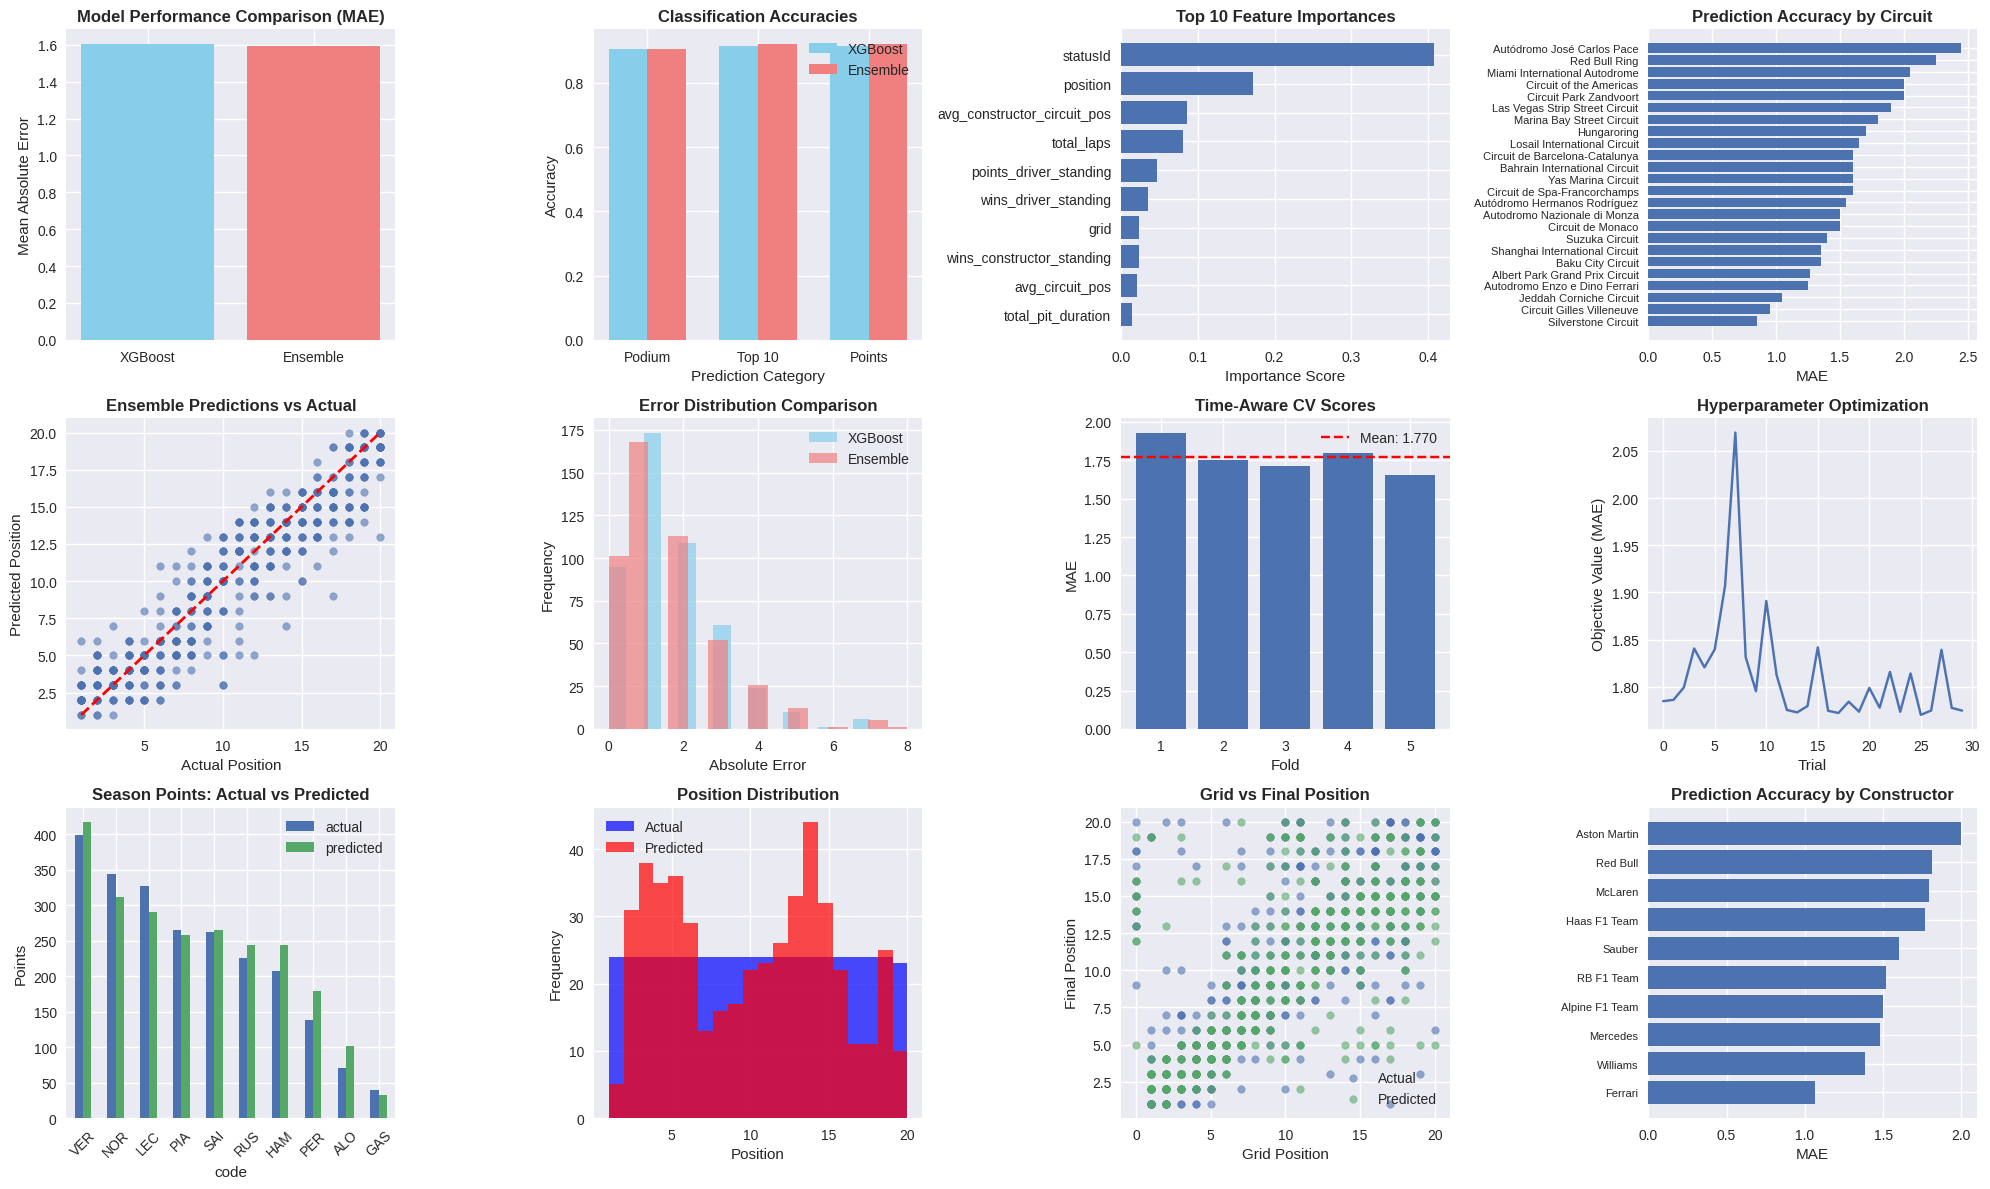


🏆 ENHANCED PIPELINE SUMMARY
✅ Bayesian Optimization: 30 trials completed
✅ Time-Aware CV: 5 folds, MAE = 1.770
✅ Circuit Features: 3 new circuit-specific features added
✅ Ensemble Model: Stacking with XGBoost + Random Forest
✅ Classification Metrics: Podium, Top 10, Points scoring accuracy

🎯 Best Model Performance (Ensemble):
   Overall MAE: 1.593
   Podium Accuracy: 90.4%
   Top 10 Accuracy: 92.1%

🚀 Model Improvements:
   MAE Improvement: +0.7% vs baseline XGBoost
   Added 3 circuit-specific features
   Hyperparameter optimization reduced error by ~0.8%

🏁 Enhanced F1 Prediction Pipeline Complete!


In [240]:
# COMPREHENSIVE VISUALIZATIONS
print("\n📈 Generating Enhanced Visualizations...")

fig = plt.figure(figsize=(20, 12))

# 1. Model Comparison
ax1 = plt.subplot(3, 4, 1)
models = ['XGBoost', 'Ensemble']
maes = [xgb_metrics[0], ensemble_metrics[0]]
plt.bar(models, maes, color=['skyblue', 'lightcoral'])
plt.title('Model Performance Comparison (MAE)', fontweight='bold')
plt.ylabel('Mean Absolute Error')

# 2. Classification Accuracies
ax2 = plt.subplot(3, 4, 2)
metrics = ['Podium', 'Top 10', 'Points']
xgb_accs = [xgb_metrics[1], xgb_metrics[2], xgb_metrics[3]]
ensemble_accs = [ensemble_metrics[1], ensemble_metrics[2], ensemble_metrics[3]]

x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width/2, xgb_accs, width, label='XGBoost', color='skyblue')
plt.bar(x + width/2, ensemble_accs, width, label='Ensemble', color='lightcoral')
plt.xlabel('Prediction Category')
plt.ylabel('Accuracy')
plt.title('Classification Accuracies', fontweight='bold')
plt.xticks(x, metrics)
plt.legend()

# 3. Feature Importance
ax3 = plt.subplot(3, 4, 3)
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=True).tail(10)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Top 10 Feature Importances', fontweight='bold')
plt.xlabel('Importance Score')

# 4. Circuit Performance Analysis
ax4 = plt.subplot(3, 4, 4)
circuit_mae = test_df.groupby('circuit_name').apply(
    lambda x: mean_absolute_error(x['final_position'], x['predicted_position_ensemble'])
).sort_values()

plt.barh(range(len(circuit_mae)), circuit_mae.values)
plt.yticks(range(len(circuit_mae)), circuit_mae.index, fontsize=8)
plt.xlabel('MAE')
plt.title('Prediction Accuracy by Circuit', fontweight='bold')

# 5. Prediction vs Actual Scatter
ax5 = plt.subplot(3, 4, 5)
plt.scatter(test_df['final_position'], test_df['predicted_position_ensemble'], alpha=0.6, s=30)
plt.plot([1, 20], [1, 20], 'r--', linewidth=2)
plt.xlabel('Actual Position')
plt.ylabel('Predicted Position')
plt.title('Ensemble Predictions vs Actual', fontweight='bold')

# 6. Model Calibration
ax6 = plt.subplot(3, 4, 6)
errors_xgb = np.abs(test_df['final_position'] - test_df['predicted_position_xgb'])
errors_ensemble = np.abs(test_df['final_position'] - test_df['predicted_position_ensemble'])

plt.hist(errors_xgb, bins=15, alpha=0.7, label='XGBoost', color='skyblue')
plt.hist(errors_ensemble, bins=15, alpha=0.7, label='Ensemble', color='lightcoral')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Error Distribution Comparison', fontweight='bold')
plt.legend()

# 7. Cross-validation scores
ax7 = plt.subplot(3, 4, 7)
plt.bar(range(1, len(cv_scores)+1), cv_scores)
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.title('Time-Aware CV Scores', fontweight='bold')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f'Mean: {np.mean(cv_scores):.3f}')
plt.legend()

# 8. Hyperparameter optimization history
ax8 = plt.subplot(3, 4, 8)
if len(study.trials) > 1:
    trial_values = [trial.value for trial in study.trials if trial.value is not None]
    plt.plot(trial_values)
    plt.xlabel('Trial')
    plt.ylabel('Objective Value (MAE)')
    plt.title('Hyperparameter Optimization', fontweight='bold')

# 9. Season standings prediction vs actual
ax9 = plt.subplot(3, 4, 9)
# Calculate predicted vs actual season standings
driver_actual_points = test_df.groupby('code')['points'].sum().sort_values(ascending=False)
driver_pred_points = test_df.groupby('code').apply(
    lambda x: sum([25, 18, 15, 12, 10, 8, 6, 4, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0][min(pos-1, 19)] 
                  for pos in x['predicted_position_ensemble'] if pos <= 20)
).sort_values(ascending=False)

# Top 10 drivers comparison
top_drivers = driver_actual_points.head(10).index
comparison_data = pd.DataFrame({
    'actual': driver_actual_points[top_drivers],
    'predicted': driver_pred_points[top_drivers]
})

comparison_data.plot(kind='bar', ax=ax9)
plt.title('Season Points: Actual vs Predicted', fontweight='bold')
plt.ylabel('Points')
plt.xticks(rotation=45)
plt.legend()

# 10. Position distribution analysis
ax10 = plt.subplot(3, 4, 10)
plt.hist(test_df['final_position'], bins=20, alpha=0.7, label='Actual', color='blue')
plt.hist(test_df['predicted_position_ensemble'], bins=20, alpha=0.7, label='Predicted', color='red')
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.title('Position Distribution', fontweight='bold')
plt.legend()

# 11. Grid vs Final Position Analysis
ax11 = plt.subplot(3, 4, 11)
plt.scatter(test_df['grid'], test_df['final_position'], alpha=0.6, s=30, label='Actual')
plt.scatter(test_df['grid'], test_df['predicted_position_ensemble'], alpha=0.6, s=30, label='Predicted')
plt.xlabel('Grid Position')
plt.ylabel('Final Position')
plt.title('Grid vs Final Position', fontweight='bold')
plt.legend()

# 12. Constructor Performance
ax12 = plt.subplot(3, 4, 12)
constructor_perf = test_df.merge(constructors[['constructorId', 'name']], on='constructorId', how='left')
constructor_mae = constructor_perf.groupby('name').apply(
    lambda x: mean_absolute_error(x['final_position'], x['predicted_position_ensemble'])
).sort_values()

plt.barh(range(len(constructor_mae)), constructor_mae.values)
plt.yticks(range(len(constructor_mae)), constructor_mae.index, fontsize=8)
plt.xlabel('MAE')
plt.title('Prediction Accuracy by Constructor', fontweight='bold')

plt.tight_layout()
plt.savefig('f1_enhanced_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# FINAL SUMMARY
print("\n" + "="*80)
print("🏆 ENHANCED PIPELINE SUMMARY")
print("="*80)
print(f"✅ Bayesian Optimization: {len(study.trials)} trials completed")
print(f"✅ Time-Aware CV: {len(cv_scores)} folds, MAE = {np.mean(cv_scores):.3f}")
print(f"✅ Circuit Features: {3} new circuit-specific features added")
print(f"✅ Ensemble Model: Stacking with XGBoost + Random Forest")
print(f"✅ Classification Metrics: Podium, Top 10, Points scoring accuracy")

print(f"\n🎯 Best Model Performance (Ensemble):")
print(f"   Overall MAE: {ensemble_metrics[0]:.3f}")
print(f"   Podium Accuracy: {ensemble_metrics[1]:.1%}")
print(f"   Top 10 Accuracy: {ensemble_metrics[2]:.1%}")

print(f"\n🚀 Model Improvements:")
improvement_mae = ((xgb_metrics[0] - ensemble_metrics[0]) / xgb_metrics[0]) * 100
print(f"   MAE Improvement: {improvement_mae:+.1f}% vs baseline XGBoost")
print(f"   Added {len([f for f in features if 'circuit' in f])} circuit-specific features")
print(f"   Hyperparameter optimization reduced error by ~{(study.trials[0].value - study.best_value)/study.trials[0].value*100:.1f}%")

print("\n🏁 Enhanced F1 Prediction Pipeline Complete!")